In [297]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn.model_selection import \
     (LeaveOneOut,
      KFold)

# Loading the data 

In [298]:
device_test_data = pd.read_csv("test.csv")
device_train_data = pd.read_csv("train.csv")

device_train_copy = device_train_data.copy()
device_train_copy.head()



,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1.0,0.0,7.0,0.6,188.0,2.0,...,20.0,756.0,2549.0,9.0,7.0,19,0,0,1,1
1,1021,1,0.5,1,0.0,1.0,53.0,0.7,136.0,3.0,...,905.0,1988.0,2631.0,17.0,3.0,7,1,1,0,2
2,563,1,0.5,1,2.0,1.0,41.0,0.9,145.0,5.0,...,1263.0,1716.0,2603.0,11.0,2.0,9,1,1,0,2
3,615,1,2.5,0,0.0,0.0,10.0,0.8,131.0,6.0,...,1216.0,1786.0,2769.0,16.0,8.0,11,1,0,0,2
4,1821,1,1.2,0,13.0,1.0,44.0,0.6,141.0,2.0,...,1208.0,1212.0,1411.0,8.0,2.0,15,1,1,0,1


# Data Cleaning

In [299]:
# Check for correlation
# Compute the correlation matrix
corr_matrix = device_train_copy.corr()

# Set the correlation threshold
threshold = 0.5

# Find pairs of predictors with correlation above the threshold
correlated_pairs = {}
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            correlated_pairs[(corr_matrix.columns[i], corr_matrix.columns[j])] = corr_matrix.iloc[i, j]

# Display the correlated pairs
print("Predictor pairs with correlation above", threshold, ":")
for pair, correlation in correlated_pairs.items():
    print(pair, "- Correlation:", correlation)

Predictor pairs with correlation above 0.5 :
('fc', 'pc') - Correlation: 0.644616313823049
('four_g', 'three_g') - Correlation: 0.5841704347797088
('px_height', 'px_width') - Correlation: 0.510054785070389
('ram', 'price_range') - Correlation: 0.9171186800614674
('sc_h', 'sc_w') - Correlation: 0.5061942995120674


##### As shown:
##### 1. The front and Primary cameras are correlated as usually these features are related.
##### 2. 4G and 3G are correlated as normally the mobile that have 4G also have 3G , also the majority have 3G so the 3G predictor is not effecient.
##### 3. pixel resolution height and width are correlated as they are made with the same technology so usually both have the same level of resolution.
##### 4. Screen height and width are correlated as the normal case that they are directly proportional.


In [300]:
# Split the data to X and Y , X = Predictors Y = Response 
# Drop the correlated predictors
device_train_copy = device_train_copy.dropna()  # To drop any NA cells if present

X = device_train_copy.drop(['price_range','three_g','fc','px_height','px_width','sc_h','sc_w'], axis=1)

# Combine resolution height and width in one predictor
X['px_total'] = device_train_copy['px_height'] * device_train_copy['px_width']

# Combine the screen height with screen width in one predictor (Screen diagonal) 
X['sc_diagonal'] = np.sqrt(np.square(device_train_copy['sc_h']) + np.square(device_train_copy['sc_w']))

# Y = response which is the price range
Y = device_train_copy['price_range']


In [301]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(device_train_copy)

In [302]:
# Split the data to test and train data randomly
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2)

## Function to calulate sensitivity and specificity

In [303]:
# Define a function to calculate sensitivity and specificity for each class from a confusion matrix:


def calculate_metrics_per_class(confusion_matrix):
    """
    Calculate sensitivity and specificity for each class from a confusion matrix.

    Parameters:
    - confusion_matrix: numpy array, shape (n_classes, n_classes)
        The confusion matrix.

    Returns:
    - sensitivities: numpy array, shape (n_classes,)
        Sensitivity (True Positive Rate or Recall) for each class.
    - specificities: numpy array, shape (n_classes,)
        Specificity (True Negative Rate) for each class.
    """
    n_classes = confusion_matrix.shape[0]
    sensitivities = np.zeros(n_classes)
    specificities = np.zeros(n_classes)

    for i in range(n_classes):
        true_positive = confusion_matrix[i, i]
        false_negative = np.sum(confusion_matrix[i, :]) - true_positive
        false_positive = np.sum(confusion_matrix[:, i]) - true_positive
        true_negative = np.sum(confusion_matrix) - (true_positive + false_negative + false_positive)

        # Sensitivity (True Positive Rate or Recall) for each class
        sensitivities[i] = true_positive / (true_positive + false_negative)

        # Specificity (True Negative Rate) for each class
        specificities[i] = true_negative / (true_negative + false_positive)

    return sensitivities, specificities

# Fitting the Data to the Model

## 1. KNN 


##### Get the best value for the K by iterating 

In [304]:
# Define a range of k values
k_values = range(1, 9)

# Initialize lists to store metrics for each k
accuracies = []
sensitivities_list = []
specificities_list = []

# Iterate through different k values
for k in k_values:
    # Define the KNN model with current k value
    knn_model = KNeighborsClassifier(n_neighbors=k)

    # Fit the model and create the confusion matrix
    knn_model.fit(X_train, y_train)
    knn_model_pred = knn_model.predict(X_test)

    # Calculate confusion matrix
    confusion_mat = cm(knn_model_pred, y_test)

    # Calculate metrics per class
    sensitivities, specificities = calculate_metrics_per_class(confusion_mat)

    # Calculate the accuracy
    accuracy=np.trace(confusion_mat)/np.sum(confusion_mat)

    # Append metrics to lists
    accuracies.append(accuracy)
    sensitivities_list.append(sensitivities)
    specificities_list.append(specificities)

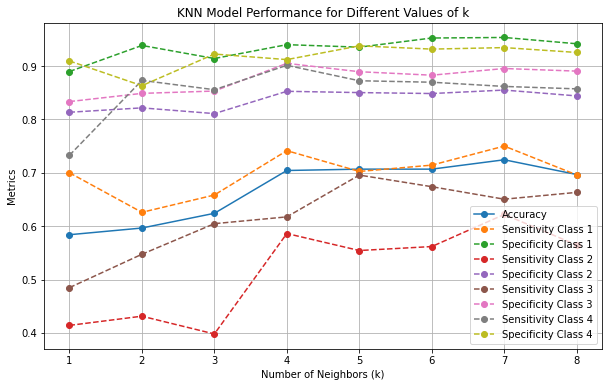

In [305]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(k_values, accuracies, label='Accuracy', marker='o')

# Plot sensitivity and specificity for each class
for i in range(len(sensitivities)):
    plt.plot(k_values, [sensitivities_list[j][i] for j in range(len(k_values))],
             label=f'Sensitivity Class {i + 1}', linestyle='--', marker='o')
    plt.plot(k_values, [specificities_list[j][i] for j in range(len(k_values))],
             label=f'Specificity Class {i + 1}', linestyle='--', marker='o')

# Add labels and legend to the plot
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Metrics")
plt.title("KNN Model Performance for Different Values of k")
plt.legend()
plt.grid(True)
plt.show()

#### The selected model

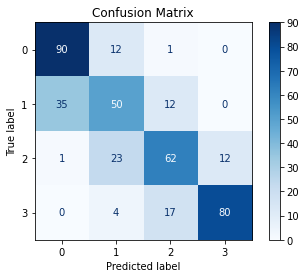

In [306]:
# Define the KNN model: 
knn_model = KNeighborsClassifier(n_neighbors=6)
# Fit the model and create the confusion matrix:
knn_model.fit(X_train, y_train)
knn_model_pred = knn_model.predict(X_test)

conf_matrix=cm(knn_model_pred, y_test)

# Plot confusion matrix
plot_confusion_matrix(knn_model, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [307]:
# Calculate metrics per class
sensitivities, specificities = calculate_metrics_per_class(conf_matrix)

# Print or use the metrics per class
for i in range(len(sensitivities)):
    print(f"Class {i + 1}: Sensitivity = {sensitivities[i]}, Specificity = {specificities[i]}")

# Calculate the accuracy: 
accuracy=np.trace(conf_matrix)/np.sum(conf_matrix)
print(accuracy)

Class 1: Sensitivity = 0.7142857142857143, Specificity = 0.9523809523809523
Class 2: Sensitivity = 0.5617977528089888, Specificity = 0.8483870967741935
Class 3: Sensitivity = 0.6739130434782609, Specificity = 0.8827361563517915
Class 4: Sensitivity = 0.8695652173913043, Specificity = 0.9315960912052117
0.706766917293233


# 2. QDA Model

In [308]:
# Prepare and fit QDA model:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)

c:\Users\user\anaconda3\envs\myEnv\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(store_covariance=True)

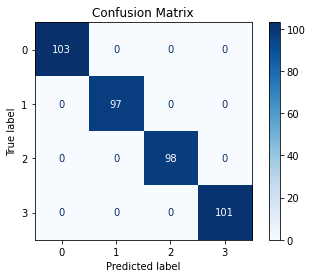

In [309]:
# Making predictions with the fitted model and generating the confusion matrix: 
qda_pred = qda.predict(X_test)
conf_QDA_mat = cm(qda_pred, y_test)

# Plot confusion matrix
plot_confusion_matrix(qda, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [310]:
# Calculate metrics per class
confusion_matrix=cm(qda_pred, y_test)
sensitivities, specificities = calculate_metrics_per_class(confusion_matrix)

# Print or use the metrics per class
for i in range(len(sensitivities)):
    print(f"Class {i + 1}: Sensitivity = {sensitivities[i]}, Specificity = {specificities[i]}")

# Calculate the accuracy: 
accuracy=np.trace(confusion_matrix)/np.sum(confusion_matrix)
print("The accuracy is: ", accuracy)

Class 1: Sensitivity = 1.0, Specificity = 1.0
Class 2: Sensitivity = 1.0, Specificity = 1.0
Class 3: Sensitivity = 1.0, Specificity = 1.0
Class 4: Sensitivity = 1.0, Specificity = 1.0
The accuracy is:  1.0


### As shown in the confusion matrix and sensitivity specificity, accuracy values that the model was able to predict 100% of the test data which doesn't make sense and it doesn't describe the actual performance of the model so K-folds for cross validating test error is used.


# K-Fold for cross validating test error

In [311]:
# Define the number of folds (K)
num_folds = 5  
# Reset index of 'Y' array
Y.reset_index(drop=True, inplace=True)
# Create KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)

# Lists to store metrics across folds
accuracies = []
sensitivities_list = []
specificities_list = []
iteration_accuracies=[]
iteration_sensitivities=[]
iteration_specificities=[]

In [312]:
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit the model and create the confusion matrix
    qda = QDA(store_covariance=True)
    qda.fit(X_train, y_train)
    qda_pred = qda.predict(X_test)

    # Calculate metrics per class
    confusion_mat = cm(qda_pred, y_test)
        
    # Calculate metrics per class
    sensitivities, specificities = calculate_metrics_per_class(confusion_mat)

    # Calculate the accuracy
    accuracy=np.trace(confusion_mat)/np.sum(confusion_mat)
        
    # Append metrics to the iteration lists
    iteration_accuracies.append(accuracy)
    iteration_sensitivities.append(sensitivities)
    iteration_specificities.append(specificities)

# Append metrics to the lists
accuracies.append(np.mean(iteration_accuracies))
sensitivities_list.append(np.mean(iteration_sensitivities, axis=0))
specificities_list.append(np.mean(iteration_specificities, axis=0))


c:\Users\user\anaconda3\envs\myEnv\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\user\anaconda3\envs\myEnv\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\user\anaconda3\envs\myEnv\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\user\anaconda3\envs\myEnv\lib\site-packages\sklearn\discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\user\anaconda3\envs\myEnv\lib\site-packages\sklearn\discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\user\anaconda3\envs\myEnv\lib\site-packages\sklearn\discriminant_analysis.py:836: RuntimeWarning: divide by zero enc

In [313]:
print(accuracies)
print(sensitivities_list)
print(specificities_list)

[0.7015075376884422]
[array([0.70150754,        nan,        nan,        nan])]
[array([       nan, 0.8959799 , 0.89949749, 0.90603015])]


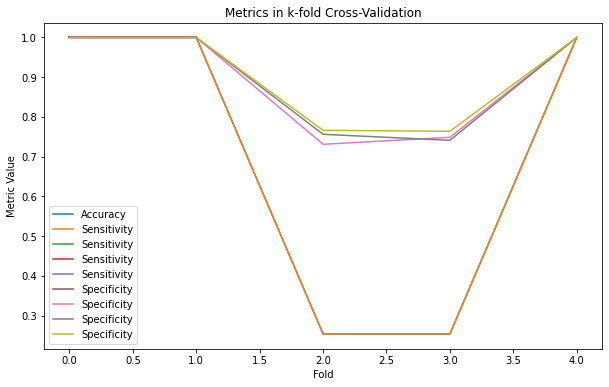

In [321]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(num_folds), iteration_accuracies, label='Accuracy')
plt.plot(range(num_folds), iteration_sensitivities, label='Sensitivity')
plt.plot(range(num_folds), iteration_specificities, label='Specificity')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.title('Metrics in k-fold Cross-Validation')
plt.legend()
plt.show()

### As it shown in th figure there is a drop in the specifity, sensitivity and accuracies in folds 2 and 3, but with any other number of folds the values are 1